In [1]:
import sys
sys.path.append('../../raNNdom')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


### 1D Poisson equation (sinusoidal exact solution):
$ \begin{cases}
            -\frac{d^2u(x)}{dx^2} = 4\pi^2sin(\pi\,x)\,cos(\pi\,x) & x \in \,\Omega \\
            u(-1) = 0,\;\;\; u(1) = 0
    \end{cases}$
    
Exact solution: $u(x) = sin(\pi\,x)\,cos(\pi\,x)$

In [2]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx - 4 * np.pi ** 2 * tf.sin(np.pi * x) * tf.cos(np.pi * x)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.sin(np.pi * x) * np.cos(np.pi * x)

geom = dde.geometry.Interval(-2, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

Compiling model...
'compile' took 0.000300 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.02e+03, 3.42e+00]    [2.92e+03, 3.42e+00]    [3.49e+00]    
1000      [1.27e+00, 6.84e-02]    [1.41e+00, 6.84e-02]    [8.94e-01]    
2000      [1.47e-01, 1.43e-03]    [1.64e-01, 1.43e-03]    [3.61e-01]    
3000      [2.05e-02, 7.69e-05]    [2.01e-02, 7.69e-05]    [7.73e-02]    
4000      [1.66e-02, 6.24e-06]    [1.60e-02, 6.24e-06]    [7.57e-03]    
5000      [1.61e-02, 3.97e-06]    [1.57e-02, 3.97e-06]    [8.08e-03]    
6000      [1.56e-02, 4.18e-06]    [1.51e-02, 4.18e-06]    [8.06e-03]    
7000      [1.47e-02, 3.90e-06]    [1.43e-02, 3.90e-06]    [7.82e-03]    
8000      [1.33e-02, 3.46e-06]    [1.29e-02, 3.46e-06]    [7.44e-03]    
9000      [1.14e-02, 2.85e-06]    [1.10e-02, 2.85e-06]    [6.89e-03]    
10000     [8.93e-03, 2.07e-06]    [8.57e-03, 2.07e-06]    [6.01e-03]    

Best model at step 10000:
  train loss: 8.93e-03
  test lo

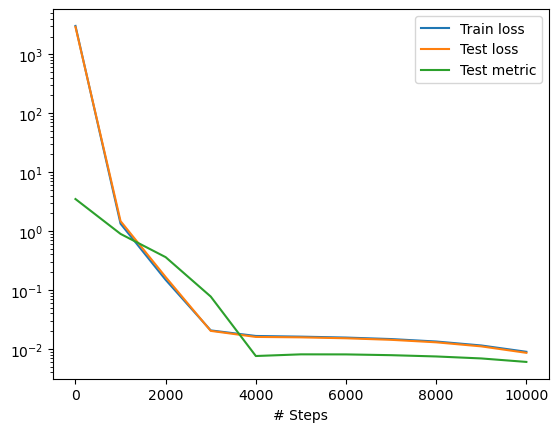

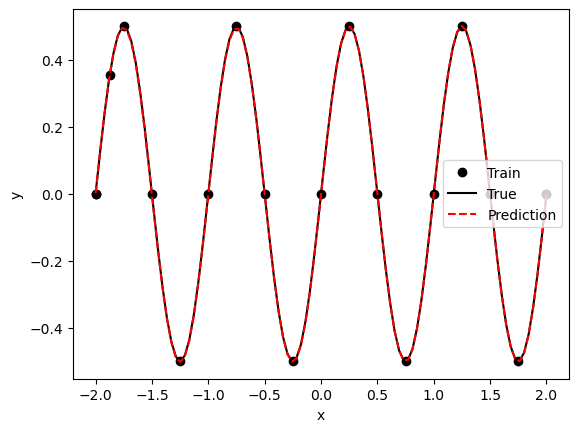

In [3]:
M =20
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [25]:
R = 10
MM = [10, 20, 50, 100, 150, 200, 300]
loss = {}
epochs = {}
metric = {}
for M in MM:
    ll = []
    layer_size = [1] + [M]  +  [1]

    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/1000)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[M] = losshistory.steps
    metric[M] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[M] = ll

Compiling model...
'compile' took 0.000381 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [5.09e+03, 9.73e-01]    [4.85e+03, 9.73e-01]    [3.09e+00]    
1000      [2.03e+01, 1.51e-01]    [1.58e+01, 1.51e-01]    [6.76e-01]    
2000      [4.70e+00, 6.87e-02]    [5.43e+00, 6.87e-02]    [5.51e-01]    
3000      [4.04e+00, 1.02e-01]    [4.82e+00, 1.02e-01]    [4.10e-01]    
4000      [3.41e+00, 1.30e-01]    [4.09e+00, 1.30e-01]    [3.61e-01]    
5000      [2.64e+00, 1.11e-01]    [3.17e+00, 1.11e-01]    [3.18e-01]    
6000      [1.77e+00, 7.08e-02]    [2.12e+00, 7.08e-02]    [2.54e-01]    
7000      [9.52e-01, 3.32e-02]    [1.14e+00, 3.32e-02]    [1.77e-01]    
8000      [4.08e-01, 9.41e-03]    [4.71e-01, 9.41e-03]    [1.08e-01]    
9000      [1.82e-01, 1.09e-03]    [1.90e-01, 1.09e-03]    [7.86e-02]    
10000     [1.15e-01, 1.75e-05]    [1.08e-01, 1.75e-05]    [7.51e-02]    

Best model at step 10000:
  train loss: 1.15e-01
  test lo

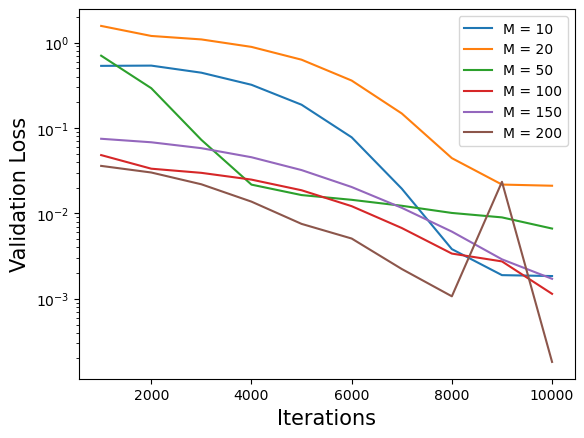

In [51]:
MM = [10, 20, 50, 100, 150, 200]

for i in MM:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'M = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

### 1D Poisson equation (Exponential exact solution):
$ \begin{cases}
            -\frac{d^2u(x)}{dx^2} = -2\,e^{x^2}\,(2\,x^2+1) & x \in \,\Omega \\
            u(-1) = e-2,\;\;\; u(1) = e+2
    \end{cases}$

Exact solution: $u(x) = e^{x^2} + 2x$


Compiling model...
'compile' took 0.000353 s

Training model...



c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss              Test loss               Test metric   
0         [7.81e+02, 9.86e+00]    [8.44e+02, 9.86e+00]    [1.16e+00]    
1000      [1.32e+01, 5.37e+00]    [1.14e+01, 5.37e+00]    [6.92e-01]    
2000      [3.24e+00, 1.30e+00]    [1.88e+00, 1.30e+00]    [3.80e-01]    
3000      [1.47e+00, 2.06e-01]    [7.10e-01, 2.06e-01]    [1.55e-01]    
4000      [5.82e-01, 3.19e-02]    [2.94e-01, 3.19e-02]    [5.89e-02]    
5000      [2.55e-01, 3.87e-03]    [1.90e-01, 3.87e-03]    [2.03e-02]    
6000      [2.07e-01, 2.26e-04]    [2.04e-01, 2.26e-04]    [4.94e-03]    
7000      [1.99e-01, 3.14e-05]    [2.04e-01, 3.14e-05]    [1.98e-03]    
8000      [1.89e-01, 2.33e-05]    [1.92e-01, 2.33e-05]    [1.69e-03]    
9000      [1.74e-01, 2.08e-05]    [1.76e-01, 2.08e-05]    [1.56e-03]    
10000     [1.52e-01, 1.79e-05]    [1.54e-01, 1.79e-05]    [1.44e-03]    
11000     [1.22e-01, 1.24e-05]    [1.25e-01, 1.24e-05]    [1.27e-03]    
12000     [8.67e-02, 8.42e-06]    [9.04e-02, 8.42e-

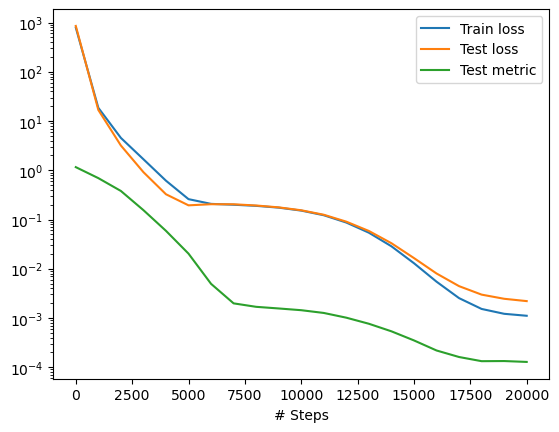

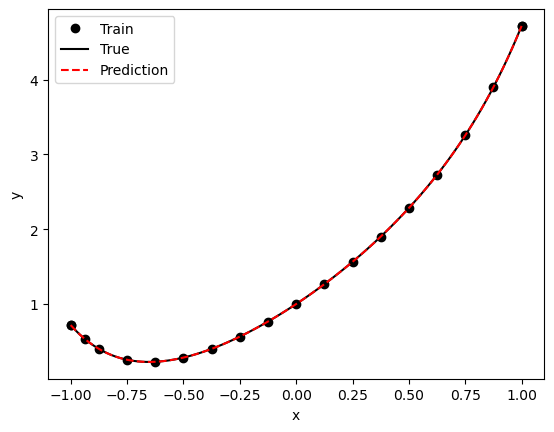

In [4]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*tf.exp(x**2) * (2*x**2 + 1)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.exp(x**2) + 2*x

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 20
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [47]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*tf.exp(x**2) * (2*x**2 + 1)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return np.exp(x**2) + 2*x

geom = dde.geometry.Interval(-1, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 100
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"

rr = [2, 4, 6, 8, 10, 12]

for R in rr:
    ll = []
    
    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[R] = losshistory.steps
    metric[R] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[R] = ll

Compiling model...
'compile' took 0.000354 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [7.71e+01, 1.10e+01]    [5.45e+01, 1.10e+01]    [8.47e-01]    
1000      [6.07e+00, 1.35e-01]    [2.36e+00, 1.35e-01]    [1.85e-01]    
2000      [2.24e+00, 1.04e-03]    [1.53e+00, 1.04e-03]    [3.36e-02]    
3000      [2.21e+00, 6.76e-05]    [1.65e+00, 6.76e-05]    [2.85e-02]    
4000      [2.19e+00, 6.08e-05]    [1.63e+00, 6.08e-05]    [2.84e-02]    
5000      [2.15e+00, 5.65e-05]    [1.61e+00, 5.65e-05]    [2.81e-02]    
6000      [2.09e+00, 5.23e-05]    [1.56e+00, 5.23e-05]    [2.77e-02]    
7000      [2.00e+00, 4.77e-05]    [1.49e+00, 4.77e-05]    [2.70e-02]    
8000      [1.86e+00, 4.16e-05]    [1.38e+00, 4.16e-05]    [2.60e-02]    
9000      [1.66e+00, 3.33e-05]    [1.23e+00, 3.33e-05]    [2.45e-02]    
10000     [1.41e+00, 2.41e-05]    [1.03e+00, 2.41e-05]    [2.24e-02]    

Best model at step 10000:
  train loss: 1.41e+00
  test loss: 1.03e+00
  test metric: [2.24e-02]

'train

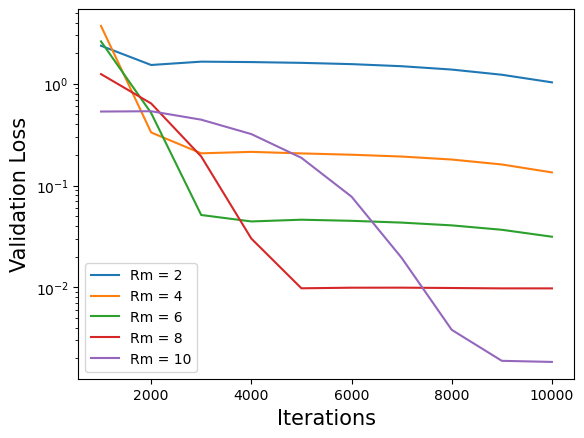

In [50]:
rr = [2, 4, 6, 8, 10]
for i in rr:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'Rm = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

### 1D Poisson equation (Polynomial exact solution):
$ \begin{cases}
            -\frac{d^2u(x)}{dx^2} = -20\,x^3-24\,x^2+6\,x+4 & x \in \,\Omega \\
            u(-2) = 1,\;\;\; u(1) = -2
    \end{cases}$

Exact solution: $u(x) = x^5+2\,x^4-x^3-2\,x^2-x-1$

Compiling model...
'compile' took 0.000484 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [5.13e+03, 3.47e+00]    [4.56e+03, 3.47e+00]    [9.76e-01]    
1000      [1.17e+00, 6.57e-01]    [7.45e-01, 6.57e-01]    [3.09e-01]    
2000      [1.61e-01, 7.10e-04]    [1.66e-01, 7.10e-04]    [2.64e-02]    
3000      [5.23e-02, 1.76e-05]    [1.12e-01, 1.76e-05]    [1.21e-02]    
4000      [3.53e-02, 1.57e-05]    [1.16e-01, 1.57e-05]    [5.51e-03]    
5000      [2.94e-02, 1.88e-05]    [1.10e-01, 1.88e-05]    [4.28e-03]    
6000      [2.33e-02, 1.17e-05]    [9.84e-02, 1.17e-05]    [3.71e-03]    
7000      [1.83e-02, 5.25e-06]    [8.70e-02, 5.25e-06]    [3.09e-03]    
8000      [1.55e-02, 1.58e-06]    [7.81e-02, 1.58e-06]    [2.52e-03]    
9000      [1.46e-02, 3.50e-07]    [7.24e-02, 3.50e-07]    [2.16e-03]    
10000     [1.43e-02, 7.41e-07]    [6.90e-02, 7.41e-07]    [2.00e-03]    
11000     [1.37e-02, 8.34e-08]    [6.45e-02, 8.34e-08]    [1.96e-03]    
12000     [1.31e-02, 7.69e-08]  

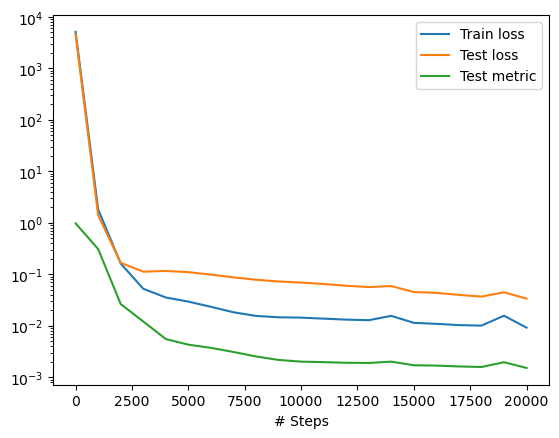

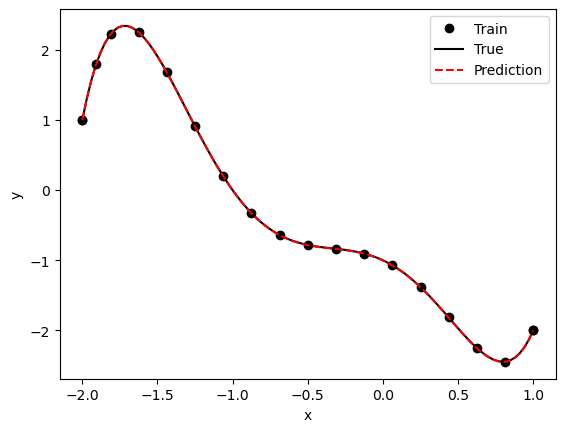

In [8]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*(10*x**3 + 12*x**2 - 3*x - 2)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return x**5 + 2*x**4 -x**3 - 2*x**2 - x - 1
geom = dde.geometry.Interval(-2, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

M = 100
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [5]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + 2*(10*x**3 + 12*x**2 - 3*x - 2)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return x**5 + 2*x**4 -x**3 - 2*x**2 - x - 1
geom = dde.geometry.Interval(-2, 1)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 16, 2, solution=func, num_test=100)

R = 10
MM = [5, 10, 20, 50, 100, 150, 200]
loss = {}
epochs = {}
metric = {}
for M in MM:
    ll = []
    layer_size = [1] + [M]  +  [1]

    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[M] = losshistory.steps
    metric[M] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[M] = ll


M = 50
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"

rr = [2, 4, 6, 8, 10, 12]

for R in rr:
    ll = []
    
    net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

    model = dde.Model(data, net)

    model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

    losshistory, train_state = model.train(iterations=10000)
    
    loss_test = losshistory.loss_test
    epochs[R] = losshistory.steps
    metric[R] = losshistory.metrics_test
    for j in range(np.shape(loss_test)[0]):
        ll.append(loss_test[j][0])
    loss[R] = ll

Compiling model...
'compile' took 0.000424 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [2.91e+03, 8.27e+00]    [2.70e+03, 8.27e+00]    [1.52e+00]    
1000      [2.35e+02, 1.48e+00]    [1.55e+02, 1.48e+00]    [9.02e-01]    
2000      [1.93e+02, 1.82e-01]    [1.21e+02, 1.82e-01]    [6.77e-01]    
3000      [1.79e+02, 4.96e-02]    [1.12e+02, 4.96e-02]    [6.98e-01]    
4000      [1.70e+02, 6.20e-01]    [1.07e+02, 6.20e-01]    [8.95e-01]    
5000      [1.64e+02, 1.63e+00]    [1.05e+02, 1.63e+00]    [1.14e+00]    
6000      [1.61e+02, 2.78e+00]    [1.04e+02, 2.78e+00]    [1.36e+00]    
7000      [1.59e+02, 3.69e+00]    [1.05e+02, 3.69e+00]    [1.51e+00]    
8000      [1.59e+02, 4.14e+00]    [1.05e+02, 4.14e+00]    [1.58e+00]    
9000      [1.59e+02, 4.24e+00]    [1.05e+02, 4.24e+00]    [1.59e+00]    
10000     [1.59e+02, 4.25e+00]    [1.05e+02, 4.25e+00]    [1.60e+00]    

Best model at step 9000:
  train loss: 1.63e+02
  test loss: 1.09e+02
  test metric: [1.59e+00]

'train'

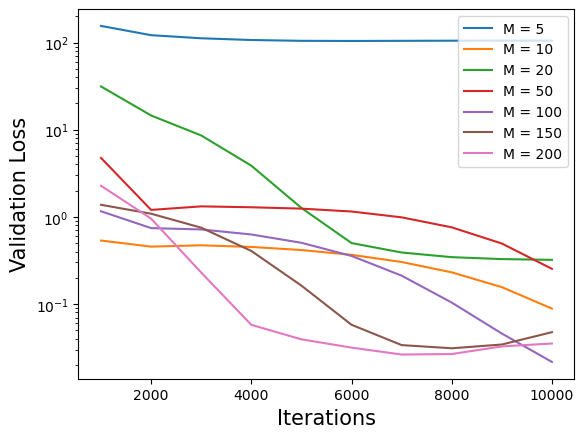

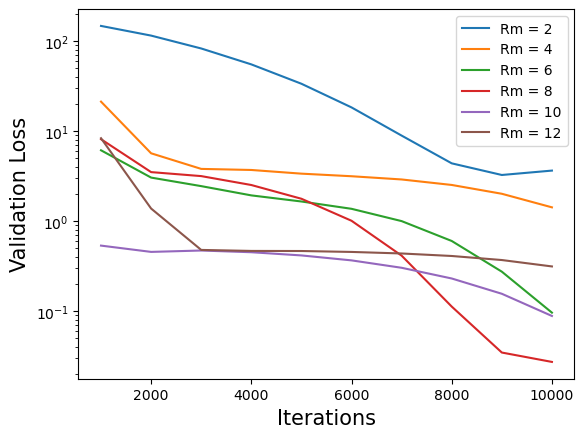

In [6]:
for i in MM:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'M = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

for i in rr:
    plt.plot(epochs[i][1:], loss[i][1:], label = 'Rm = ' + str(i))
plt.yscale('log')
#plt.title('Validation Loss')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Validation Loss', fontsize=15)
plt.legend()
plt.show()

### $1^{st}$ numerical result $(\Omega = [-3, \,2])$
$\begin{cases}
    -\frac{d^2u(x)}{dx^2} + u(x) = 0.5\,x^5 + 1.3\,x^4 - 12.7\,x^3 - 21.1\,x^2 + 18.9\,x + 13.3& x \in \,\Omega \\
    u(-3) = 1.4,\;\;\; u(2) = 0.9
\end{cases}$

Exact solution: $u(x) = 0.5\,x^5 + 1.3\,x^4 - 2.7\,x^3 - 5.5\,x^2 + 2.7\,x + 2.3$

Compiling model...
'compile' took 0.000698 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.05e+03, 4.09e+00]    [2.11e+03, 4.09e+00]    [9.98e-01]    
1000      [2.59e+01, 8.97e-01]    [2.61e+01, 8.97e-01]    [4.02e-01]    
2000      [8.68e+00, 3.31e-02]    [3.97e+01, 3.31e-02]    [2.94e-01]    
3000      [4.06e+00, 9.00e-03]    [2.55e+01, 9.00e-03]    [1.63e-01]    
4000      [1.20e+00, 2.35e-03]    [1.37e+01, 2.35e-03]    [6.11e-02]    
5000      [2.66e-01, 2.92e-04]    [7.91e+00, 2.92e-04]    [4.49e-02]    
6000      [1.47e-01, 1.45e-05]    [6.12e+00, 1.45e-05]    [6.18e-02]    
7000      [1.41e-01, 1.71e-06]    [5.86e+00, 1.71e-06]    [6.47e-02]    
8000      [1.36e-01, 1.33e-06]    [5.87e+00, 1.33e-06]    [6.34e-02]    
9000      [1.29e-01, 1.22e-06]    [5.82e+00, 1.22e-06]    [6.15e-02]    
10000     [1.20e-01, 1.04e-06]    [5.63e+00, 1.04e-06]    [5.91e-02]    

Best model at step 10000:
  train loss: 1.20e-01
  test lo

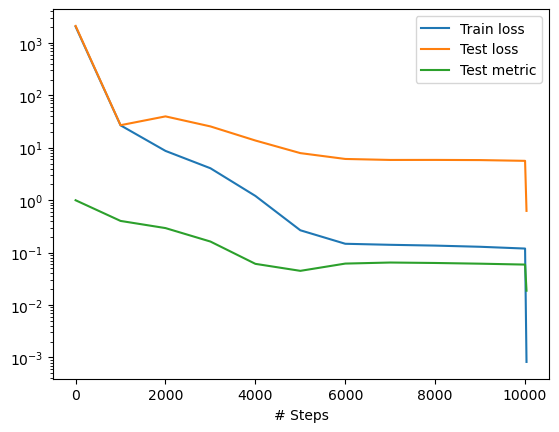

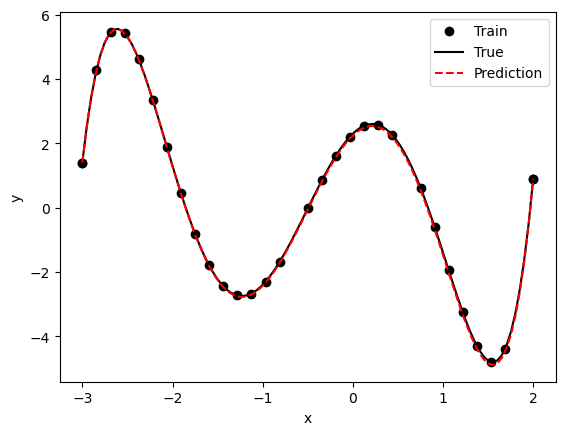

In [6]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    return -dy_xx + y + 10*x**3 + 15.6*x**2 - 16.2*x - 11 \
        - (0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return 0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 28, 2, solution=func, num_test=100)

M = 100
layer_size = [1] + [M]  +  [1]

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"
R = 10
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

##### Sensitivity Analysis on Random Feature Method

In [21]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx + y + 10*x**3 + 15.6*x**2 - 16.2*x - 11 \
        - (0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return 0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3

def max(l):
    maxx = 1e9
    for i in range(np.shape(l)[0]):
        if maxx > l[i][0]:
            maxx = l[i][0]
    return maxx

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 36, 2, solution=func, num_test=100)

activation = ["random_sin", 'linear']

initializer = "Glorot uniform"

MM = [25, 50, 100, 150, 200, 250]
rr = [2, 4, 6, 8, 10]
loss = {}
for M in MM:
    for R in rr:
        key = str(M) + ' ' + str(R)
        layer_size = [1] + [M]  +  [1]
        
        net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R)

        model = dde.Model(data, net)

        model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

        losshistory, train_state = model.train(iterations=30000)
        key = key + ', ' + str(losshistory.steps[-1])
        loss[key] = losshistory.loss_test[-1]

Compiling model...
'compile' took 0.000556 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.24e+03, 1.67e+00]    [8.67e+02, 1.67e+00]    [1.05e+00]    
17        [1.90e-02, 5.86e-10]    [1.82e-02, 5.86e-10]    [5.76e-03]    

Best model at step 17:
  train loss: 1.90e-02
  test loss: 1.82e-02
  test metric: [5.76e-03]

'train' took 2.103984 s

Compiling model...
'compile' took 0.000234 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.47e+03, 3.46e+00]    [9.91e+02, 3.46e+00]    [9.96e-01]    
22        [7.35e-03, 1.58e-10]    [8.58e-03, 1.58e-10]    [5.01e-03]    

Best model at step 22:
  train loss: 7.35e-03
  test loss: 8.58e-03
  test metric: [5.01e-03]

'train' took 2.626829 s

Compiling model...
'compile' took 0.000240 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [2.08e+03, 4.82e+00]    [1.35e+03, 4.82e+0

In [22]:
print(loss)

{'25 2, 17': array([1.8203802e-02, 5.8577143e-10], dtype=float32), '25 4, 22': array([8.5770860e-03, 1.5830892e-10], dtype=float32), '25 6, 22': array([9.9593727e-04, 5.3724136e-11], dtype=float32), '25 8, 22': array([5.362238e-02, 2.824466e-07], dtype=float32), '25 10, 25': array([5.4678404e-01, 7.1861456e-07], dtype=float32), '50 2, 13': array([1.7946202e-02, 1.1114594e-09], dtype=float32), '50 4, 19': array([4.6190359e-03, 1.0030021e-09], dtype=float32), '50 6, 26': array([3.0218863e-03, 5.2079940e-10], dtype=float32), '50 8, 25': array([1.07086964e-01, 3.10532528e-07], dtype=float32), '50 10, 33': array([9.169350e-03, 9.784017e-09], dtype=float32), '100 2, 12': array([1.6760444e-02, 6.6620487e-11], dtype=float32), '100 4, 17': array([4.8554889e-03, 1.8435742e-10], dtype=float32), '100 6, 23': array([4.7989823e-03, 1.2250201e-09], dtype=float32), '100 8, 32': array([3.1043153e-04, 5.9774408e-12], dtype=float32), '100 10, 33': array([3.6652807e-02, 1.0936725e-07], dtype=float32), '15

##### Sensitivity Analysis on classic PINN implementation

In [19]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx + y + 10*x**3 + 15.6*x**2 - 16.2*x - 11 \
        - (0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3)
def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    return 0.5*x**5 + 1.3*x**4 - 2.7*x**3 - 5.5*x**2 + 2.7*x + 2.3

geom = dde.geometry.Interval(-3, 2)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 36, 2, solution=func, num_test=100)
MM = [25, 50, 100, 150, 200, 250]
activation = ["random_sin", 'linear']
initializer = "Glorot uniform"
loss = {}
for M in MM:
    layer_size = [1] + [M]  +  [1]
    net = dde.nn.FNN(layer_size, activation, initializer)

    model = dde.Model(data, net)

    model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"], loss_weights=1)

    losshistory, train_state = model.train(iterations=50000)
    key = str(M) + ', ' + str(losshistory.steps[-1])
    loss[key] = losshistory.loss_test[-1]

Compiling model...
'compile' took 0.000450 s

Training model...

Step      Train loss              Test loss               Test metric   


c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


0         [1.23e+03, 2.02e+01]    [8.52e+02, 2.02e+01]    [1.65e+00]    
904       [2.82e-01, 3.12e-06]    [2.44e-01, 3.12e-06]    [1.51e-02]    

Best model at step 904:
  train loss: 2.82e-01
  test loss: 2.44e-01
  test metric: [1.51e-02]

'train' took 92.571577 s

Compiling model...
'compile' took 0.000282 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.23e+03, 3.19e+01]    [8.51e+02, 3.19e+01]    [1.86e+00]    
1313      [6.47e-02, 4.19e-07]    [5.79e-02, 4.19e-07]    [7.47e-03]    

Best model at step 1313:
  train loss: 6.47e-02
  test loss: 5.79e-02
  test metric: [7.47e-03]

'train' took 155.921832 s

Compiling model...
'compile' took 0.000241 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.22e+03, 2.90e+01]    [8.47e+02, 2.90e+01]    [1.79e+00]    
1494      [1.10e-02, 2.29e-07]    [8.75e-03, 2.29e-07]    [4.00e-03]    

Best model at step 1494:
  train loss

In [20]:
print(loss)

{'25, 904': array([2.4384548e-01, 3.1183586e-06], dtype=float32), '50, 1313': array([5.7871047e-02, 4.1919844e-07], dtype=float32), '100, 1494': array([8.7472685e-03, 2.2880118e-07], dtype=float32), '150, 814': array([1.3053408e-01, 6.0392194e-05], dtype=float32), '200, 1284': array([5.9859887e-02, 4.0583978e-07], dtype=float32), '250, 8': array([836.3552  ,   5.242422], dtype=float32)}
